In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

## Question 1

The *Gibbs sampler* in class for the prior $p(\theta,\tau) \propto 1$ was created by alternatingly sampling from the *full conditional* $p(\theta|\tau,\textbf{x})$ *normal* and  $p(\tau|\theta,\textbf{x})$ *gamma* distributions. Create this *Gibbs sampler* so your code can be used for the sample `x = stats.norm(loc=m, scale=s).rvs(size=n)` for any arbitrary `n`, `m`, and `s`.

*Use the code below or your own code to <u>provide a demonstration of Bayesian inference<u> for this data and model specification.*


In [38]:
def gibbs_sampler(n, m, s, C=2, G=10000):
    x = stats.norm(loc=m, scale=s).rvs(size=n)

    theta,tau = np.zeros([C,G]),np.zeros([C,G])
    theta[:, 0] = 1000  # Arbitrary large initial value for theta

    # Gibbs sampling
    for c in range(C):  # For each chain
        for g in range(1, G):
            tau[c,g] = stats.gamma(a=n/2 + 1, scale=2/((x-theta[c,g-1])**2).sum()).rvs()
            theta[c,g] = stats.norm(x.mean(), scale = 1/(tau[c,g]*n)**0.5).rvs()
    
    return theta, tau

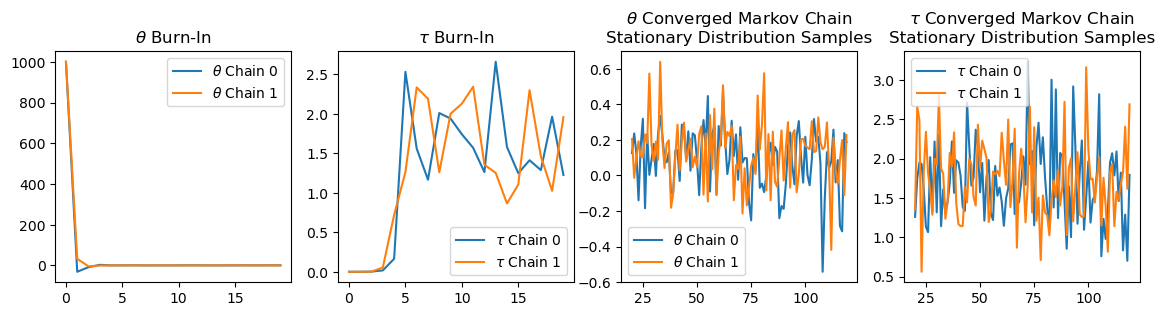

In [39]:
C,G = 2,10000  # chains, Gibbs samples
theta, tau = gibbs_sampler(20, 0, 1)
fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 20
demo = 120
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend(); 

95% Credible interval for theta (for one chain):  [-69.88080073 -26.84419603]
95% Credible interval for tau (for one chain):  [23.40696729 60.91358441]
there is a 95% chance that the true value of theta is between -69.881 and -26.844
there is a 95% chance that the true value of tau is between 23.407 and 60.914


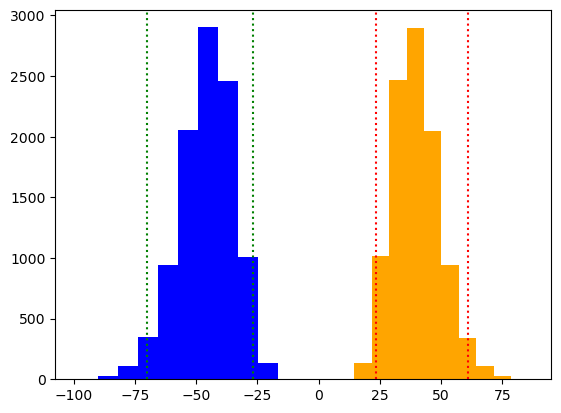

In [47]:
# bayesian inference
plt.hist(theta[0, burn:], color='blue')
theta_samples = theta[0, burn:]
theta_ci = np.quantile(theta_samples, [0.025, 0.975])
# ci line dotted
plt.axvline(theta_ci[0], color='green', linestyle='dotted')
plt.axvline(theta_ci[1], color='green', linestyle='dotted')


plt.hist(tau[0, burn:], color='orange')

tau_samples = tau[0, burn:]
tau_ci = np.quantile(tau_samples, [0.025, 0.975])
# ci line
plt.axvline(tau_ci[0], color='red', linestyle='dotted')
plt.axvline(tau_ci[1], color='red', linestyle='dotted')

print("95% Credible interval for theta (for one chain): ", theta_ci)
print("95% Credible interval for tau (for one chain): ", tau_ci)
print("there is a 95% chance that the true value of theta is between", round(theta_ci[0], 3), "and", round(theta_ci[1], 3))
print("there is a 95% chance that the true value of tau is between", round(tau_ci[0], 3), "and", round(tau_ci[1], 3))

## Question 2

Derive the *full conditional distributions* $p(\tau|\theta, \mathbf{x})$ and $p(\theta|\tau, \mathbf{x})$ if $p(\theta)$ is $N(\theta_0, \tau^2_0)$ and $p(\tau) \propto \tau^{\frac{\alpha}{2}-1} e^{- \frac{\lambda}{2} \tau}$. 

*Explain how to equate $\alpha$ and $\lambda$ with controlling the amount and nature of information the prior contributes to the posterior. How can we interpret these as controlling a "number of data points" contributed by the prior relative to the number of data points contributed to the posterior through the likelihoood?*

Create an updated version of the *Gibbs sampler* for $N(\theta_0, \tau^2_0)$ and $\textrm{gamma}(\textrm{shape}=\frac{\alpha}{2}, \textrm{rate}=\frac{\lambda}{2})$ priors for $p(\theta)$ and $p(\tau)$ respectively. 

*Demonstrate how changing the prior hyperparameters influences the posterior relative to the sample and the likelihood.*


### 2.1 Derivation: 
$$
\begin{aligned}
p(\tau|\theta, \mathbf{x}) &\propto p(\mathbf{x}|\theta,\tau)p(\tau|\theta) =p(\mathbf{x}|\theta, \tau) p(\tau) \\
&= \prod_{i=1}^{n}\left[ \sqrt{\frac{\tau}{2\pi}}e^{-\frac{\tau}{2}(x_i - \theta)^2} \right]\cdot \tau^{\frac{\alpha}{2}-1}e^{-\frac{\lambda}{2}\tau}\\
&\propto \tau^{\frac{n}{2}}e^{-\frac{\tau}{2}\sum_{i=1}^{n}(x_i-\theta)^2} \cdot \tau^{\frac{\alpha}{2}-1}e^{-\frac{\lambda}{2}\tau}\\
&\propto \tau^{\frac{n}{2}+\frac{\alpha}{2}-1}\cdot e^{-\frac{\tau}{2}\sum_{i=1}^{n}(x_i- \theta)^2 -\frac{\tau}{2}\lambda}\\

&= \tau^{\frac{n}{2}+\frac{\alpha}{2}-1}\cdot e^{-\frac{\tau}{2}(\lambda +\sum_{i=1}^{n}(x_i- \theta)^2)} \\
& \sim \text{Gamma}(\alpha^\prime, \lambda^\prime)\\  &= \text{Gamma} \left(\alpha^\prime =\frac{n}{2} + \frac{\alpha}{2}, \lambda^\prime = \frac{\lambda + \sum_{i=1}^{n}(x_i-\theta)^2}{2}\right)\\
\end{aligned}
$$

$$\begin{aligned}
p(\theta|\tau, \mathbf{x}) &\propto p(\mathbf{x}|\theta, \tau)p(\theta|\tau)=p(\mathbf{x}|\theta, \tau) p(\theta) \\
&=\prod_{i=1}^{n}\left[ \sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau}{2}(x_i - \theta)^2}\right] \cdot \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}(\theta-\theta_0)^2}
\\
&\propto e^{-\frac{\tau}{2}\sum_{i=1}^{n}(x_i-\theta)^2} \cdot e^{-\frac{\tau_0}{2}(\theta-\theta_0)^2}
\\
&\propto e^{-\frac{\tau}{2}\sum_{i=1}^{n}\left[(x_i-\theta)^2\right] -   \frac{\tau_0}{2}(\theta-\theta_0)^2                  }
\\
&\propto e^{-\frac{1}{2}\left[\tau\sum_{i=1}^{n}x_i^2 - 2\tau\theta\sum_{i=1}^{n}x_i + n\tau\theta^2  +\tau_0\theta^2 -2\tau_0\theta_0\theta +\tau\theta_0^2  \right]}
\\
&\propto e^{-\frac{1}{2}\left[\theta^2(n\tau+\tau_0) -2\theta(\tau\sum_{i=1}^{n}x_i + \theta_0\tau_0)     \right]   }

\\
&\propto e^{-\frac{n\tau + \tau_0}{2} \left[ \theta^2 - 2\theta \left(   \frac{\tau \sum_{i=1}^{n}x_i + \theta_0 \tau_0 }{n \tau + \tau_0}   \right)   \right]}

\\
&\sim N(\theta^\prime, \tau^\prime)\\
&\sim N(\theta^\prime = \frac{\tau \sum_{i=1}^{n}x_i + \theta_0 \tau_0 }{n \tau + \tau_0}, \tau^\prime = n\tau +\tau_0)
\end{aligned}
$$


### 2.2 Effect of Hyperparameters

$\alpha$ is the shape parameter of the Gamma prior on $\tau$ (precision). Since the conjugate prior for the normal distribution's precision is a Gamma distribution, the posterior update follows:

$\alpha' = \alpha + \frac{n}{2}$

where n is the number of observed data points. This means:

$\alpha$ behaves like an effective sample size for the prior precision.
A larger $\alpha$ means the prior contributes more information about the precision $\tau$, making it less dependent on the observed variance in the data.
A smaller $\alpha means the prior contributes less information, allowing the data to have more influence on estimating the posterior variance.


$\lambda$ appears in the rate parameter of the Gamma prior on $\tau$, influencing the posterior update:

$
\lambda' = \lambda + \frac{1}{2} \sum (x_i - \bar{x})^2
$

where $\sum (x_i - \bar{x})^2$ is the sum of squared deviations in the data. This means:

A larger $\lambda$ makes the prior precision more dominant, reducing the impact of individual data points in determining the posterior variance. A smaller $\lambda$ allows the variance observed in the data to have more influence on the posterior precision.

Create an updated version of the *Gibbs sampler* for $N(\theta_0, \tau_0)$ and $\textrm{gamma}(\textrm{shape}=\frac{\alpha}{2}, \textrm{rate}=\frac{\lambda}{2})$ priors for $p(\theta)$ and $p(\tau)$ respectively. 


In [48]:
def updated_gibbs_sampler(n, data, alpha, lambd, theta0, tau0, C=2, G=10000):
    """
    """
    theta, tau = np.zeros([C, G]), np.zeros([C, G])
    theta[:, 0] = theta0  # Initial value for theta
    tau[:, 0] = tau0  # Initial value for tau (precision)

    # Gibbs sampling
    for c in range(C):  # For each chain
        for g in range(1, G):
            # Sample tau from its conditional posterior
            alpha_prime = n/2 + alpha
            lambd_prime = data.sum() / 2 + lambd
            tau[c, g] = stats.gamma(
                a=alpha_prime,
                scale=1/lambd_prime
            ).rvs()
            
            # Sample theta from its conditional posterior
            theta_prime = (tau[c,g] * data.sum() + theta0 * tau0) / (n*tau[c,g] + tau0)
            tau_prime = n * tau[c,g] + tau0
            theta[c, g] = stats.norm(
                loc=theta_prime,
                scale=tau_prime**-0.5
            ).rvs()
    
    return theta, tau

### 2.3 Updated Gibbs Sampler

95% Credible interval for theta: (for one chain) [0.19384052 0.68464998]
95% Credible interval for tau: (for one chain) [1.29145996 3.38481393]
there is a 95% chance that the true value of theta is between 0.194 and 0.685
there is a 95% chance that the true value of tau is between 1.291 and 3.385


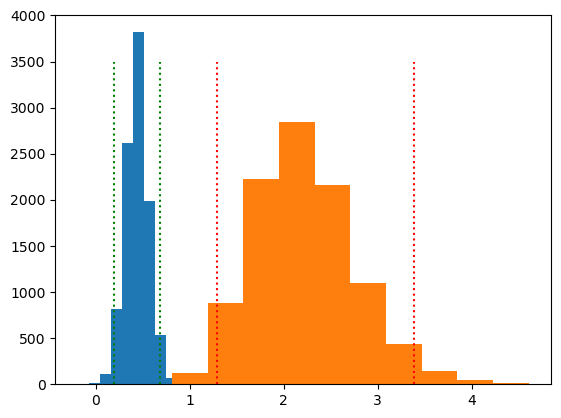

In [ ]:
np.random.seed(0)
n = 30
data = stats.norm(loc=0, scale=1).rvs(size=n) 
alpha = 2
lambd = 1
theta0 = 0
tau0 = 1

# Run updated Gibbs sampler
theta, tau = updated_gibbs_sampler(n, data, alpha, lambd, theta0, tau0)

# bayesian inference
burn = 20

plt.hist(theta[0, burn:])
theta_samples = theta[0, burn:]
theta_ci = np.quantile(theta_samples, [0.025, 0.975])

plt.hist(tau[0, burn:])
tau_samples = tau[0, burn:]
tau_ci = np.quantile(tau_samples, [0.025, 0.975])

plt.vlines(theta_ci[0], 0, 3500, color='green', linestyle='dotted')
plt.vlines(theta_ci[1],0, 3500, color='green', linestyle='dotted')
plt.vlines(tau_ci[0], 0, 3500, color='red', linestyle='dotted')
plt.vlines(tau_ci[1], 0, 3500, color='red', linestyle='dotted')
print("95% Credible interval for theta: (for one chain)", theta_ci)
print("95% Credible interval for tau: (for one chain)", tau_ci)
print("there is a 95% chance that the true value of theta is between", round(theta_ci[0], 3), "and", round(theta_ci[1], 3))
print("there is a 95% chance that the true value of tau is between", round(tau_ci[0], 3), "and", round(tau_ci[1], 3))

### 2.4 Effect of prior hyperparameters

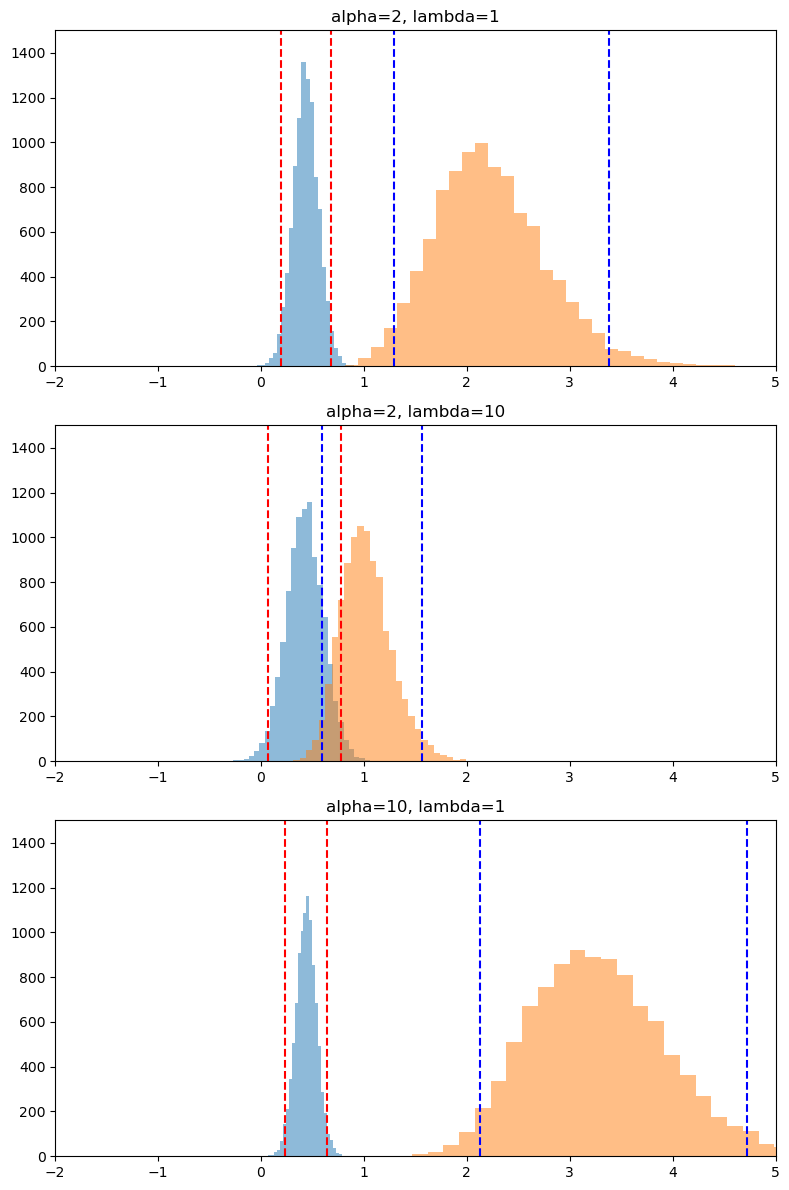

orange histogram is for theta, blue histogram is for tau


In [53]:
np.random.seed(0)
n = 30
hyperparameters = [(2, 1), (2, 10), (10, 1)]
fig, ax = plt.subplots(3, 1, figsize=(8, 12))

for i, (alpha, lambd) in enumerate(hyperparameters):
    theta, tau = updated_gibbs_sampler(n, data, alpha, lambd, theta0, tau0)
    theta_samples = theta[0, burn:]
    tau_samples = tau[0, burn:]
    theta_ci = np.quantile(theta_samples, [0.025, 0.975])
    tau_ci = np.quantile(tau_samples, [0.025, 0.975])

    ax[i].hist(theta_samples, bins=30, alpha=0.5)
    ax[i].set_xlim(-2, 5)
    ax[i].set_ylim(0, 1500)  
    ax[i].set_title(f"alpha={alpha}, lambda={lambd}")
    ax[i].axvline(theta_ci[0], color="red", linestyle="--")
    ax[i].axvline(theta_ci[1], color="red", linestyle="--")
    
    # tau visualization
    ax[i].hist(tau_samples, bins=30, alpha=0.5)
    ax[i].set_xlim(-2, 5)
    ax[i].set_ylim(0, 1500) 
    ax[i].axvline(tau_ci[0], color="blue", linestyle="--")
    ax[i].axvline(tau_ci[1], color="blue", linestyle="--")

plt.tight_layout()
plt.show()
print("orange histogram is for theta, blue histogram is for tau")

## Question 3

**(B)**: 

Based on Bayes Theorem:

$$p(\theta|\mathbf{x})p(\mathbf{x}) = p(\mathbf{x}|\theta)p(\theta) \implies p(\theta|\mathbf{x}) = \frac{p(\mathbf{x}|\theta) p(\theta)}{p(\mathbf{x})}$$

So if the prior is a proper probability distribution, Bayes theorem ensure that the posterior is proportional to the joint:
$$p(\theta|\mathbf{x}) \propto p(\mathbf{x}|\theta)p(\theta)$$

Given this proportionality, we can identify distribution of the posterior by inspecting the joint distribution through dependency on the parameter of interest $\theta$.